# Multiscale and Wideband Imaging Demo

This simulation and imaging demo is meant to convey the following

 - How to simulate interferometery data with interesting sky structures that include multi-scale and spectral features.
 - Run Cube, MFS, and MT-MFS imaging to showcase the effects of multi-frequency observations.
 - Compare Hogbom, MS-Clean and ASP-Clean for Cubes
 - (Later) Compare MS-MT-MFS-Clean with ASP-MT-Clean for Wideband imaging. 
 

## Metrics for evaluation/comparison

 - RMS of the residual image. How close is it to input noise levels ? Or zero for no-noise.
 - Goodness of fit : Mean-square deviation between the restored image and a smoothed true model. 
  
 - Runtime : 
     - Absolute runtime for scientifically equivalent runs. Hogbom -> MSClean -> ASP will have niter decreasing but loopgain increasing. (Do residuals go up with higher loop gain?) 
     - Runs with different algorithms but identical iteration controls. Measure "time per iteration". 

## Make an empty Measurement Set

In [184]:
%run -i Sim_Multiscale_Wideband_Script.py
%run -i Display_Experiments_Script.py
#%matplotlib widget
#%matplotlib inline

In [185]:
makeMSFrame(msn='sim_data', tel='VLA')

Making an MS named : sim_data_VLA.ms


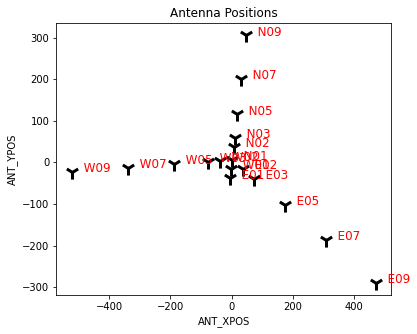

In [186]:
XPlot(vis='sim_data_VLA.ms', ptype='plotants')#,forceconvert=True)

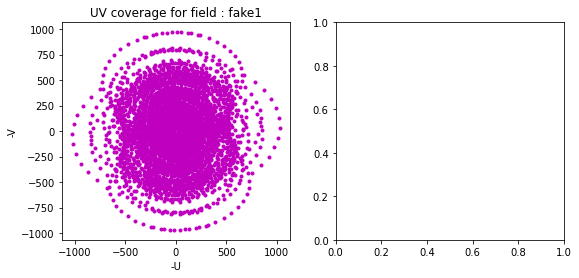

In [187]:
XPlot(vis='sim_data_VLA.ms', ptype='uvcov')

In [188]:
listobs_jupyter(vis='sim_data_VLA.ms')

           MeasurementSet Name:  /export/home/riya/rurvashi/Work/SimScripts/Sim_Notebooks/sim_data_VLA.ms      MS Version 2
   Observer: CASA simulator     Project: CASA simulation  
Observation: VLA(18 antennas)
Data records: 2754       Total elapsed time = 36000 seconds
   Observed from   03-Oct-2020/21:18:42.8   to   04-Oct-2020/07:18:42.8 (UTC)

Fields: 1
  ID   Code Name                RA               Decl           Epoch   SrcId      nRows
  0         fake1               19:59:28.500000 +40.40.00.00000 J2000   0           2754
Spectral Windows:  (1 unique spectral windows and 1 unique polarization setups)
  SpwID  Name   #Chans   Frame   Ch0(MHz)  ChanWid(kHz)  TotBW(kHz) CtrFreq(MHz)  Corrs  
  0      LBand      5   TOPO    1000.000    200000.000   1000000.0   1400.0000   RR  LL
Antennas: 18 'name'='station' 
   ID=   0-5: 'W01'='P', 'W02'='P', 'W03'='P', 'W05'='P', 'W07'='P', 'W09'='P', 
   ID=  6-11: 'E01'='P', 'E02'='P', 'E03'='P', 'E05'='P', 'E07'='P', 'E09'='P', 
   ID= 12

## Make a True Sky Model 

There are three options in this script
- 'basic' : Two point sources with alpha=0.0 and -0.5, and one round Gaussian with sigma of 7.0arcmin and alpha=-1.0
- 'simple' : Two overlapping Gaussians with positive and negative spectral index, creating spectral curvature in the middle requring a higher order spectral fit in that region. Plus, two control point sources
- 'jet' : A jet+lobe structure with multiscale structure in the lobe and a narrow line of emission in the jet. The edges of the narrow line is a use case where mtmfs sometimes has a hard time getting the spectral index right.

True spectral index values may be derived either from the simulation script, or by calculating a pixel-by-pixel spectral fit to the smoothed truth image cube below. 

In [189]:
#source = 'basic'
#source = 'simple'
source = 'jet'

In [190]:
%run -i Sim_Multiscale_Wideband_Script.py
%run -i Display_Experiments_Script.py

## Make the component list
makeCompList(clname_true='sim_'+source+'_vla.cl',tel='VLA',stype=source)
## Make an empty CASA image
makeEmptyImage(imname_true='sim_'+source+'_vla.im',tel='VLA')
## Evaluate the component list onto the CASA image
evalCompList(clname='sim_'+source+'_vla.cl', imname='sim_'+source+'_vla.im')

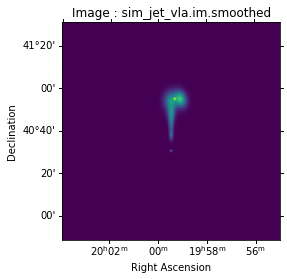

In [191]:
## Smooth to an angular resolution of 60arcsec. This is approx what mfs will give. 
smoothModel(imname='sim_'+source+'_vla.im',rbeam='60arcsec')
displayImage(imname='sim_'+source+'_vla.im.smoothed')#,scale='sqrt')

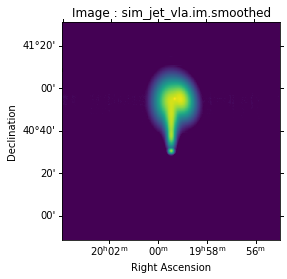

In [192]:
### Display with a different colormap stretch to see the fainter emission
displayImage(imname='sim_'+source+'_vla.im.smoothed',scale='sqrt')

Frequencies (Ghz) :  [1.  1.2 1.4 1.6 1.8]
Start fitting...
Save outputs


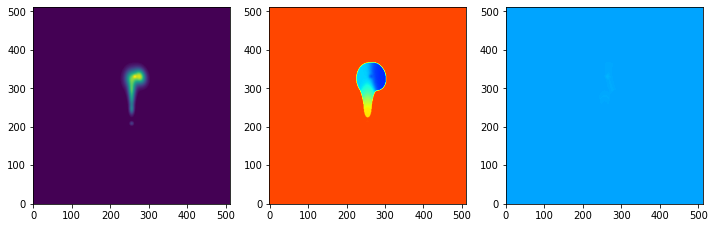

In [193]:
## Smooth to an angular resolution of 100 arcsec. This is what Cube will need to smooth to the lowest resolution. 
%run -i Sim_Multiscale_Wideband_Script.py
smoothModel(imname='sim_'+source+'_vla.im',rbeam='100arcsec')
fit_spectrum(cubename='sim_'+source+'_vla.im.smoothed',
             intensity='sim_'+source+'_int.im',
             alpha='sim_'+source+'_alpha.im',
             beta='sim_'+source+'_beta.im',
             pixt=0.15)

## Simulate visibilities from the sky model

Simulate visibilities for the true sky model, using the standard gridder (no primary beams)

In [194]:
%run -i Sim_Multiscale_Wideband_Script.py
%run -i Display_Experiments_Script.py


In [195]:
predictImager(msname='sim_data_VLA.ms',
              imname_true='sim_'+source+'_vla.im', 
              tel='VLA',
              gridder='standard')
copyModelToData(msname='sim_data_VLA.ms')

['fake1']


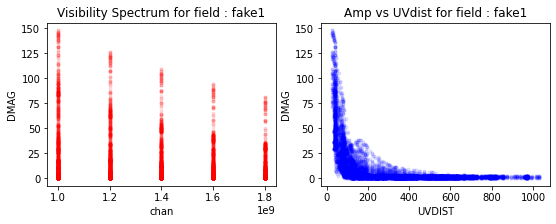

In [196]:
XPlot(vis='sim_data_VLA.ms', ptype='amp-freq-uvdist')#,forceconvert=True)

In [197]:
### Add noise.... later
#addNoiseSim(msname='sim_data_VLA.ms')

## Run Imaging Tests

### Hogbom Cube

In [198]:
%run -i Sim_Multiscale_Wideband_Script.py
%run -i Display_Experiments_Script.py


In [199]:
os.system('rm -rf try_cube_hogbom.*')
rec = tclean(vis='sim_data_VLA.ms',imagename='try_cube_hogbom',imsize=512,cell='12.0arcsec',
       specmode='cube',interpolation='nearest',nchan=5,start='1.0GHz',width='0.2GHz',
       pblimit=-1e-05,deconvolver='hogbom',niter=10000, gain=0.2, 
             interactive=0,mask='circle[[256pix,256pix],150pix]')
np.save('try_cube_hogbom.summary.npy', rec) 

## 50k iterations to do the best it can

Residual RMS : 0.0054159


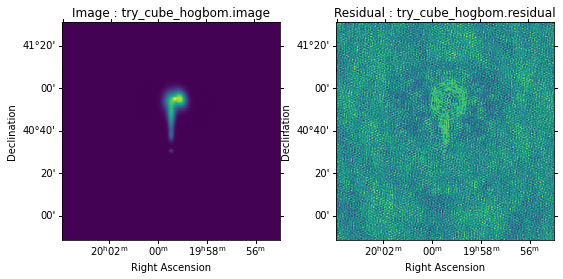

In [200]:
display_image(imprefix='try_cube_hogbom')

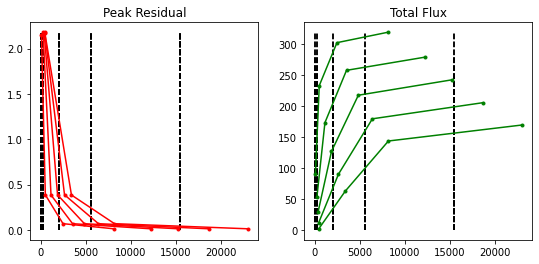

In [201]:
%run -i Display_Experiments_Script.py
PlotConvergence('try_cube_hogbom.summary.npy')

Frequencies (Ghz) :  [1.  1.2 1.4 1.6 1.8]
Start fitting...
Save outputs


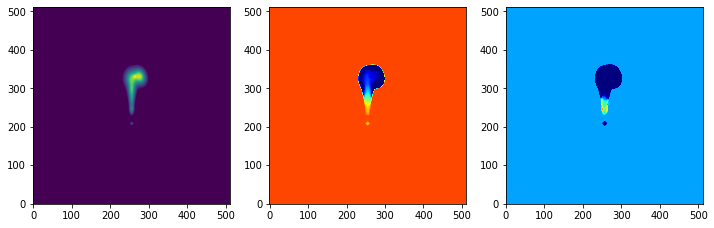

In [202]:
smoothModel(imname='try_cube_hogbom.image',rbeam='100.0arcsec')
fit_spectrum(cubename='try_cube_hogbom.image.smoothed',
             intensity='try_cube_hogbom.intensity',
             alpha='try_cube_hogbom.alpha',
             beta='try_cube_hogbom.beta',
             pixt=0.5)

Standard deviation of diff (chan 0) = 0.004013.


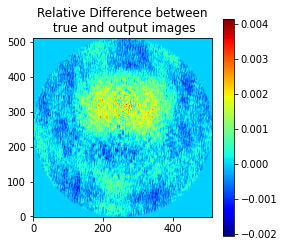

In [203]:
calcImageAccuracy(truthimage='sim_'+source+'_vla.im.smoothed', 
                  outputimage='try_cube_hogbom.image.smoothed')

### Multiscale Cube

In [204]:
os.system('rm -rf try_cube_multiscale.*')
rec = tclean(vis='sim_data_VLA.ms',imagename='try_cube_multiscale',imsize=512,cell='12.0arcsec',
       specmode='cube',interpolation='nearest',nchan=5,start='1.0GHz',width='0.2GHz',
       pblimit=-1e-05,deconvolver='multiscale',niter=10000,gain=0.2, 
             scales=[0,3,10],interactive=0,mask='circle[[256pix,256pix],150pix]')
np.save('try_cube_multiscale.summary.npy', rec) 

Residual RMS : 0.0022993


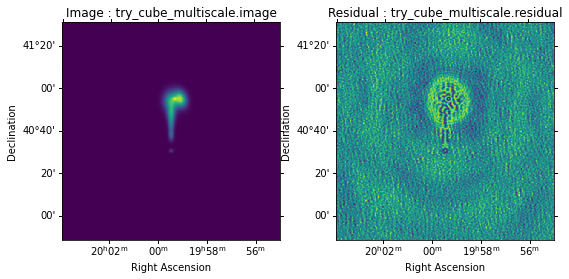

In [205]:
display_image(imprefix='try_cube_multiscale')

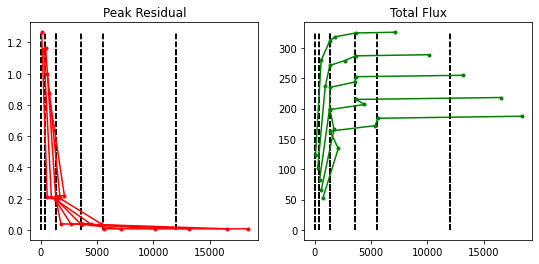

In [206]:
PlotConvergence('try_cube_multiscale.summary.npy')

Frequencies (Ghz) :  [1.  1.2 1.4 1.6 1.8]
Start fitting...
Save outputs


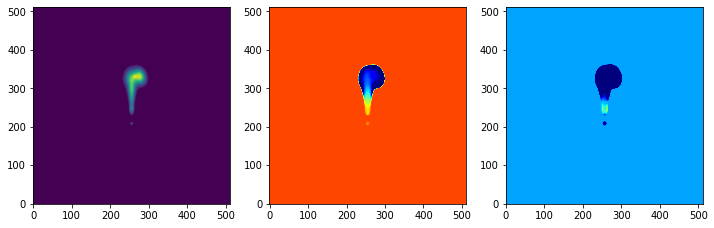

In [207]:
smoothModel(imname='try_cube_multiscale.image',rbeam='100.0arcsec')
fit_spectrum(cubename='try_cube_multiscale.image.smoothed',
             intensity='try_cube_multiscale.intensity',
             alpha='try_cube_multiscale.alpha',
             beta='try_cube_multiscale.beta',
             pixt=0.5)

Standard deviation of diff (chan 0) = 0.001458.


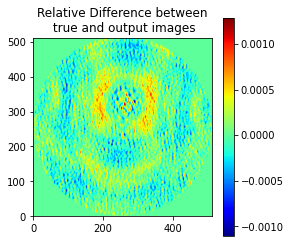

In [208]:
calcImageAccuracy(truthimage='sim_'+source+'_vla.im.smoothed', 
                  outputimage='try_cube_multiscale.image.smoothed')

### ASP Cube

In [209]:
os.system('rm -rf try_cube_asp.*')
rec = tclean(vis='sim_data_VLA.ms',imagename='try_cube_asp',imsize=512,cell='12.0arcsec',
       specmode='cube',interpolation='nearest',nchan=5,start='1.0GHz',width='0.2GHz',
       pblimit=-1e-05,deconvolver='asp',niter=10000,gain=0.2,
                 interactive=0,mask='circle[[256pix,256pix],150pix]')
np.save('try_cube_asp.summary.npy', rec) 
## Using gain=0.1 will make it take a very long time !

Residual RMS : 0.0117100


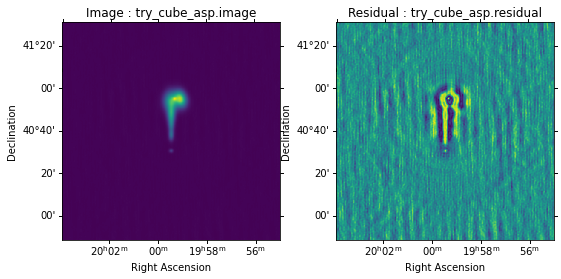

In [210]:
display_image(imprefix='try_cube_asp')

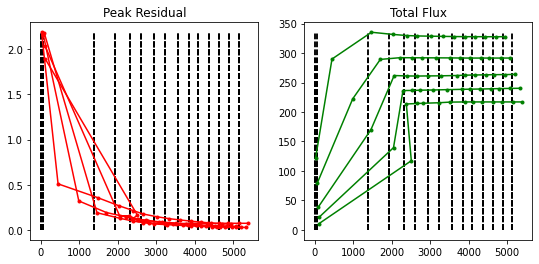

In [211]:
PlotConvergence('try_cube_asp.summary.npy')

Frequencies (Ghz) :  [1.  1.2 1.4 1.6 1.8]
Start fitting...
Save outputs


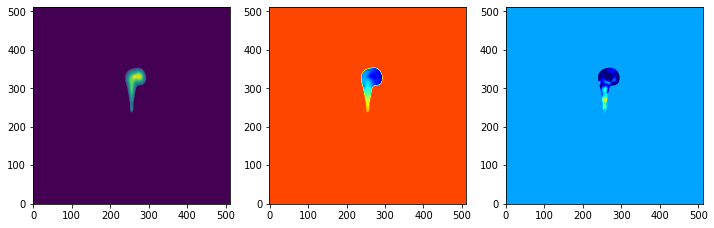

In [212]:
smoothModel(imname='try_cube_asp.image',rbeam='100.0arcsec')
fit_spectrum(cubename='try_cube_asp.image.smoothed',
             intensity='try_cube_asp.intensity',
             alpha='try_cube_asp.alpha',
             beta='try_cube_asp.beta',
             pixt=1.5)

Standard deviation of diff (chan 0) = 0.010653.


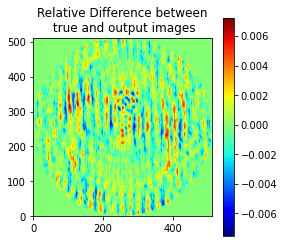

In [213]:
calcImageAccuracy(truthimage='sim_'+source+'_vla.im.smoothed', 
                  outputimage='try_cube_asp.image.smoothed')

Run ASP again, but with a higher loop gain and fewer iterations.... it gets to convergence faster.....

In [214]:
os.system('rm -rf try_cube_asp_fast.*')
rec = tclean(vis='sim_data_VLA.ms',imagename='try_cube_asp_fast',imsize=512,cell='12.0arcsec',
       specmode='cube',interpolation='nearest',nchan=5,start='1.0GHz',width='0.2GHz',
       pblimit=-1e-05,deconvolver='asp',niter=4000,gain=0.8,fusedthreshold=0.05,
                 interactive=0,mask='circle[[256pix,256pix],150pix]')
np.save('try_cube_asp_fast.summary.npy', rec) 
## Using gain=0.1 will make it take a very long time !

Residual RMS : 0.0045768


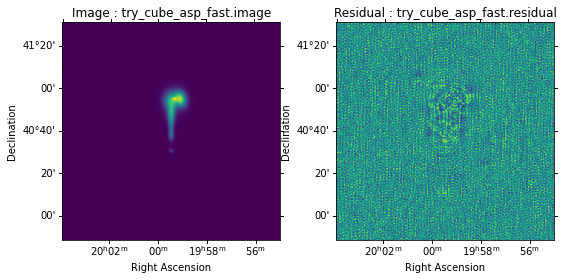

In [215]:
display_image(imprefix='try_cube_asp_fast')

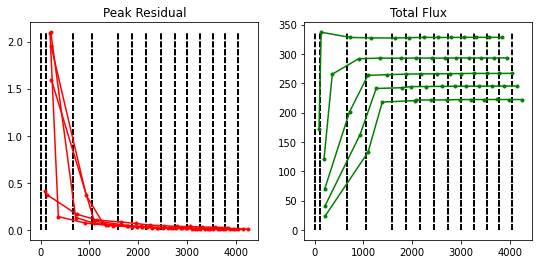

In [216]:
PlotConvergence('try_cube_asp_fast.summary.npy')

Frequencies (Ghz) :  [1.  1.2 1.4 1.6 1.8]
Start fitting...
Save outputs


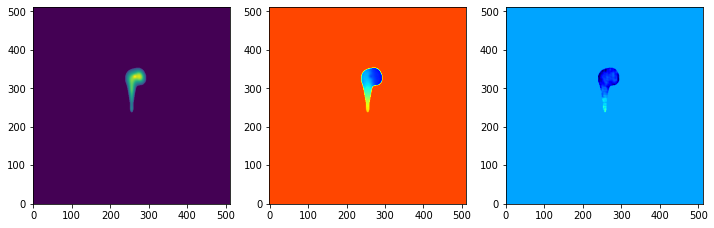

In [217]:
smoothModel(imname='try_cube_asp_fast.image',rbeam='100.0arcsec')
fit_spectrum(cubename='try_cube_asp_fast.image.smoothed',
             intensity='try_cube_asp_fast.intensity',
             alpha='try_cube_asp_fast.alpha',
             beta='try_cube_asp_fast.beta',
             pixt=1.5)

Standard deviation of diff (chan 0) = 0.003776.


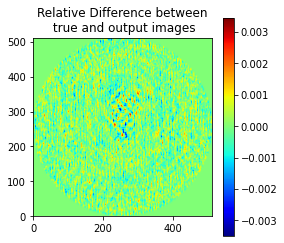

In [218]:
calcImageAccuracy(truthimage='sim_'+source+'_vla.im.smoothed', 
                  outputimage='try_cube_asp_fast.image.smoothed')

### MT-MFS with multiscale

Image with MTMFS and multiple scales. 

In [219]:
os.system('rm -rf try_mtmfs.*')
tclean(vis='sim_data_VLA.ms',imagename='try_mtmfs',imsize=512,cell='12.0arcsec',
       specmode='mfs',reffreq='1.5GHz',pblimit=-1e-05,nterms=2,
       deconvolver='mtmfs',niter=10000,cycleniter=500,scales=[0,3,6,12],mask='circle[[256pix,256pix],150pix]')

{}

In [220]:
# Recalculate spectral index above a threshold
widebandpbcor(vis='sim_data_VLA.ms', imagename='try_mtmfs',nterms=2,threshold='0.5Jy',
             action='calcalpha')
os.system('mv try_mtmfs.alpha try_mtmfs.original.alpha')
os.system('mv try_mtmfs.image.alpha try_mtmfs.alpha')

0

Residual RMS : 0.0025384


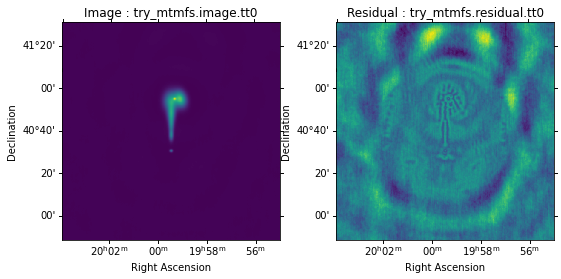

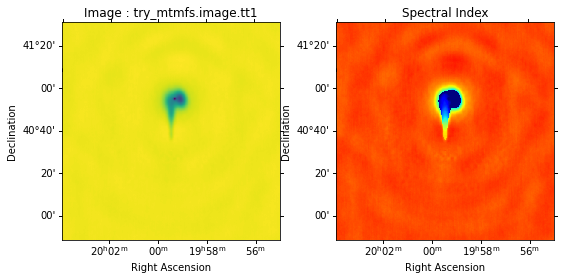

In [221]:
%run -i Display_Experiments_Script.py
display_image(imprefix='try_mtmfs',multiterm=True)


## Metrics

### Convergence Plots
See above...   move the plots here later.

### Image fidelity 
See above... make a table here later